<a href="https://colab.research.google.com/github/SaswataH/Bionic-Arm/blob/main/Gesture_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing required libraries and files

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('https://raw.githubusercontent.com/SaswataH/Bionic-Arm/refs/heads/main/hand_data.csv')
df

: 

## Consistency check in data

In [ ]:
print(df.shape)
print(df.info())
print(df.isnull().sum())

(344, 64)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      344 non-null    float64
 1   y0      344 non-null    float64
 2   z0      344 non-null    float64
 3   x1      344 non-null    float64
 4   y1      344 non-null    float64
 5   z1      344 non-null    float64
 6   x2      344 non-null    float64
 7   y2      344 non-null    float64
 8   z2      344 non-null    float64
 9   x3      344 non-null    float64
 10  y3      344 non-null    float64
 11  z3      344 non-null    float64
 12  x4      344 non-null    float64
 13  y4      344 non-null    float64
 14  z4      344 non-null    float64
 15  x5      344 non-null    float64
 16  y5      344 non-null    float64
 17  z5      344 non-null    float64
 18  x6      344 non-null    float64
 19  y6      344 non-null    float64
 20  z6      344 non-null    float64
 21  x7      344 non-null    float

## Class Balance Check
Ensure balanced gesture classes

label
fist         131
thumbs_up    113
open         100
Name: count, dtype: int64


<Axes: title={'center': 'Gesture Class Distribution'}, xlabel='label'>

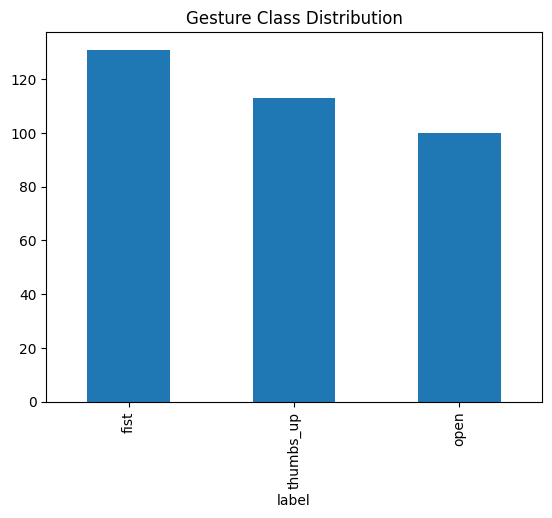

In [ ]:
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar', title='Gesture Class Distribution')

## Summary Statistics
landmark positions vary across gestures

               x0          y0            z0          x1          y1  \
count  344.000000  344.000000  3.440000e+02  344.000000  344.000000   
mean     0.309366    0.664259 -1.974428e-07    0.333778    0.617402   
std      0.068806    0.143269  4.967208e-07    0.065664    0.111072   
min      0.088449    0.139061 -1.103305e-06    0.157389    0.184599   
25%      0.262577    0.555381 -5.616744e-07    0.287527    0.550270   
50%      0.316555    0.673560 -3.747472e-07    0.333604    0.605134   
75%      0.356401    0.777601  3.278037e-07    0.380332    0.695689   
max      0.502590    0.969833  9.818191e-07    0.522971    0.873256   

               z1          x2          y2          z2          x3  ...  \
count  344.000000  344.000000  344.000000  344.000000  344.000000  ...   
mean    -0.015557    0.371877    0.555513   -0.029567    0.395113  ...   
std      0.021610    0.097819    0.111305    0.032499    0.122718  ...   
min     -0.080943    0.126622    0.217772   -0.127660    0.11603

<Axes: title={'center': 'Average Landmark Positions per Gesture'}>

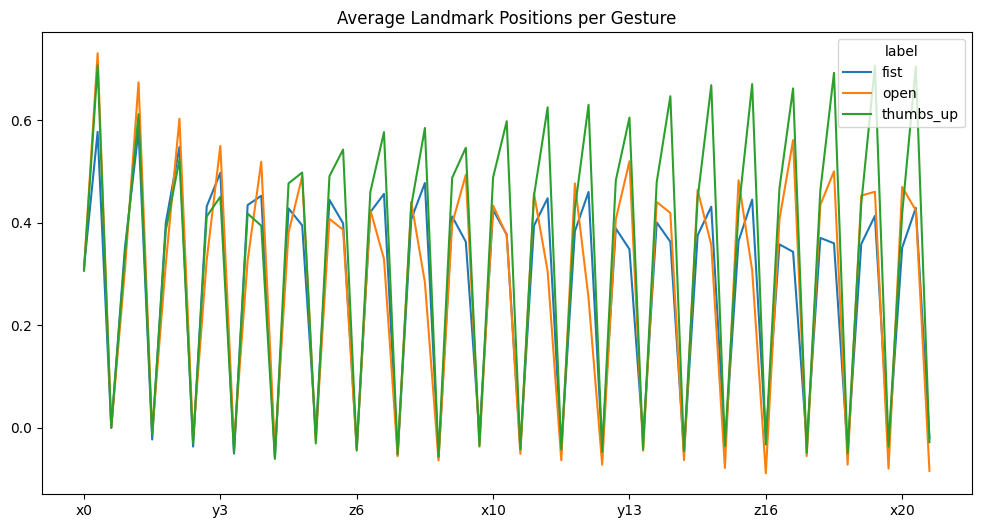

In [ ]:
print(df.describe())
df.groupby('label').mean().T.plot(figsize=(12,6), title='Average Landmark Positions per Gesture')

## Correlation Analysis
Spot multicollinearity → may drop redundant features or reduce dimensions later

<Axes: >

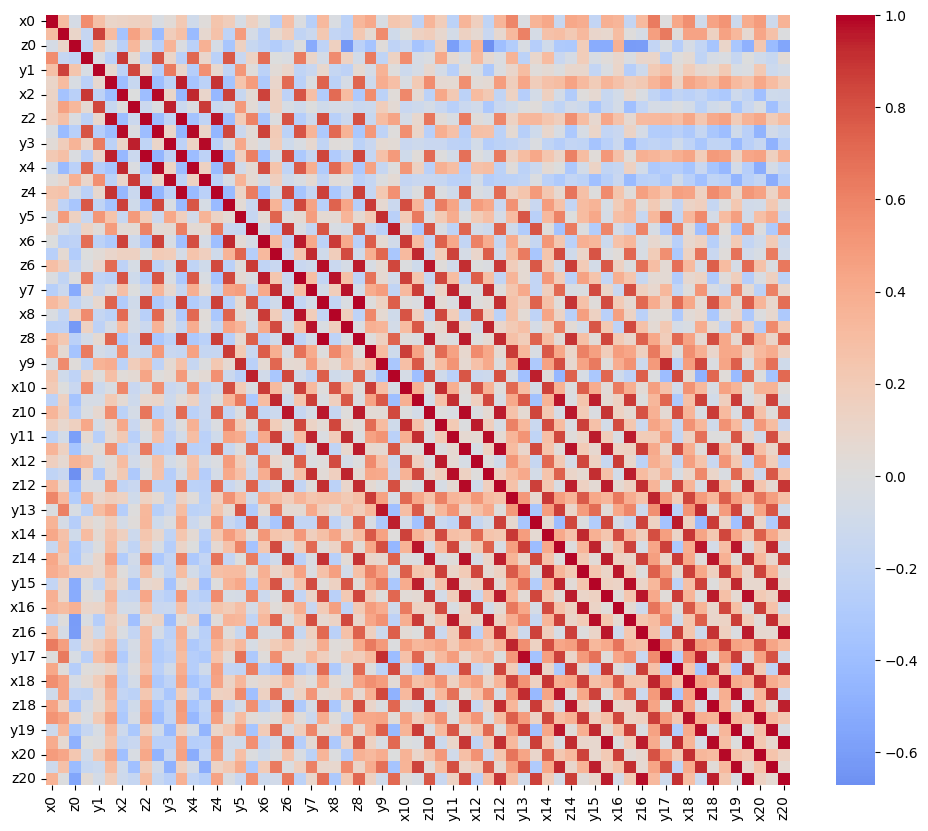

In [ ]:
corr_matrix = df.drop(columns=['label']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)

## Outlier Detection
Flag or remove noisy data that could skew training

In [ ]:
z_scores = df.drop(columns=['label']).apply(zscore)
outliers = (abs(z_scores) > 3).any(axis=1)
print(f"Outliers found: {outliers.sum()}")

# Optional: Remove outliers
df_cleaned = df[~outliers]

Outliers found: 22


## Dimensionality Reduction
Visualize cluster separation and gesture distinctiveness using t-SNE

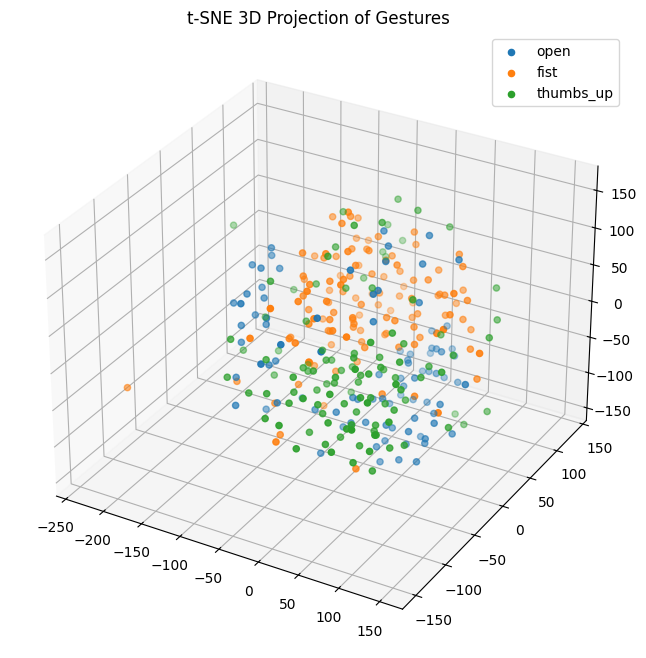

In [ ]:
X = df_cleaned.drop(columns=['label'])
y = df_cleaned['label']
X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gesture in y.unique():
    idx = y == gesture
    ax.scatter(X_embedded[idx, 0], X_embedded[idx, 1], X_embedded[idx, 2], label=gesture)

ax.set_title('t-SNE 3D Projection of Gestures')
ax.legend()

## Feature Engineering
Capture spatial structure

In [ ]:
def compute_pairwise_distances(row):
    coords = np.array(row).reshape(-1, 3)
    dists = []
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            d = np.linalg.norm(coords[i] - coords[j])
            dists.append(d)
    return pd.Series(dists)

X_new = df_cleaned.drop(columns=['label']).apply(compute_pairwise_distances, axis=1)
X_new['label'] = y.reset_index(drop=True)

## Feature Importance
Know which features are most discriminative for gestures

<Axes: title={'center': 'Top Features'}>

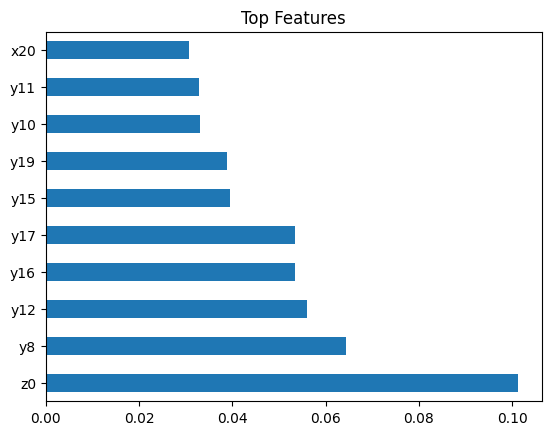

In [ ]:
X = df_cleaned.drop(columns=['label'])
y = df_cleaned['label']
clf = RandomForestClassifier()
clf.fit(X, y)

importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh', title='Top Features')